In [1]:
import matplotlib.pyplot as plt

import numpy as np
from validation.data import (
    load_from_jsonl,
)

from validation.analysis import (
    process_data,
    plot_classification_results,
    find_optimal_bounds_parallel,
    classify_data,
    plot_length_vs_distance_comparison,
)



DATA_PATHS = {
    "honest_qwen2.5_7": "../resources/Qwen2.5-7B-Instruct-quantized.w8a16-fp8___Qwen2.5-7B-Instruct-quantized.w8a16-fp8__alpaca_final.jsonl",
    "fraud_qwen2.5_7": "../resources/Qwen2.5-7B-Instruct-AWQ-int4___Qwen2.5-7B-Instruct-quantized.w8a16-fp8__alpaca_final.jsonl",

    "honest_qwen3_32": "../resources/Qwen3-32B-FP8-fp8___Qwen3-32B-FP8-fp8__alpaca_final_repro.jsonl",
    "fraud_qwen3_32": "../resources/Qwen3-32B-quantized.w4a16-int4___Qwen3-32B-FP8-fp8__alpaca_final.jsonl",

    "honest_qwen3_235": "../resources/Qwen3-235B-A22B-Instruct-2507-FP8-fp8___Qwen3-235B-A22B-Instruct-2507-FP8-fp8__alpaca_final.jsonl",
    "fraud_qwen3_235": "../resources/Qwen3-235B-A22B-Instruct-2507-INT4-W4A16-int4___Qwen3-235B-A22B-Instruct-2507-FP8-fp8__alpaca_final.jsonl",
}

In [2]:
data_path_to_fit = {}
data_path_to_distances = {}

def plot_results(name, comparison):
    distances_honest = data_path_to_distances[comparison["honest"]]
    distances_fraud = data_path_to_distances[comparison["fraud"]]
    
    optimal_lower, optimal_upper = find_optimal_bounds_parallel(distances_honest, distances_fraud, n_jobs=64, step=0.001)
    
    classifications_full = classify_data(distances_honest, optimal_lower, optimal_upper)
    classifications_fraud = classify_data(distances_fraud, optimal_lower, optimal_upper)

    honest_items = load_from_jsonl(comparison["honest"])
    fraud_items = load_from_jsonl(comparison["fraud"])
    
    plot_classification_results(
        distances_honest, classifications_full, optimal_lower, optimal_upper, title_prefix="Classification results for honest inference (FP8 vs FP8, different machines)"
    )
    plot_classification_results(
        distances_fraud, classifications_fraud, optimal_lower, optimal_upper, title_prefix="Classification results for fraudulent inference (FP8 vs INT4, different machines)"
    )

    plot_length_vs_distance_comparison(name, honest_items, distances_honest, fraud_items, distances_fraud)

for name, data_path in DATA_PATHS.items():
    items = load_from_jsonl(data_path, n=100000)
    items, distances, top_k_matches_ratios = process_data(items)
    data_path_to_distances[data_path] = distances



Dropped 0 / 1000 items
Dropped 0 / 1000 items
Dropped 0 / 1000 items
Dropped 0 / 1000 items
Dropped 0 / 1000 items
Dropped 0 / 1000 items


In [3]:
comparisons = {
    "RedHatAI/Qwen2.5-7B-Instruct-quantized.w8a16":
     {
        "honest": DATA_PATHS["honest_qwen2.5_7"],
        "fraud": DATA_PATHS["fraud_qwen2.5_7"]
     },
    "Qwen/Qwen3-32B-FP8":
     {
        "honest": DATA_PATHS["honest_qwen3_32"],
        "fraud": DATA_PATHS["fraud_qwen3_32"]
     },
    "Qwen/Qwen3-235B-A22B-Instruct-2507-FP8":
     {
        "honest": DATA_PATHS["honest_qwen3_235"],
        "fraud": DATA_PATHS["fraud_qwen3_235"]
     }
}

# Introduction

Below are illustrations of classification using the found estimations for th ebest distance threshold.

There are 3 pairs of graphs, each pair consists of honest inference-validation (in FP8) and fraudulent (quantized INT4) inference + honest (fp8) validation.

- Full classification counts is just a bar chart of the number of TP for detecting honest inference.
- Full distances classification is illustration of how far typical distances are related to the threshold.
- Quant classification counts shows classification results for the fraudulent inference.
- Quant distances classification shows how distance thresholds relates to the typical distance range for the fraudulent inference.

For each of the 3 models we have these 4 graphs that depict how well can we distinguish honest and quantized inference using the distance threshold.

For honest cases, inference and validation are computed on different machines with different GPUs (as much as possible) to guarantee that noise due to different hardware taken into account.

Data to reproduce: https://drive.google.com/drive/folders/1ehpcVC0pGw0XwrchXZUxTTRy1KdhBxrz?usp=drive_link



## Punishment procedure

### Detection

Each inference is validated by a majority vote, with each validator's vote weighted by their reputation score. If a validator suspects fraud, it can trigger a consensus check. The final decision on whether the inference is correct is determined by this consensus.
History of participant's inference results are checked by stat test and made decision if it was fraud. In that case, participant status is changed to INVALID. This happens if their inferences meet either of the following criteria (`x/inference/keeper/msg_server_validation.go:calculateStatus()`):

Consecutive Failures: The probability of their consecutive validation failures is less than 0.000001 (e.g., 5 consecutive failures with a 5% false positive rate).
Statistical Anomaly: The observed false positive (FP) rate was statistically significantly higher than the expected rate of 0.05.

The reputation of participant who is close to fail this test is decreased.

### Penalties

1. Collateral Slash: 20% of the participant's collateral is burned (`x/inference/keeper/collateral.go:CheckAndSlashForInvalidStatus()`).
2. Reward Forfeiture: All rewards for the epoch are forfeited, as work from INVALID participants is not counted during reward calculation (`x/inference/keeper/accountsettle.go:getSettleAmount()`).
3. Immediate Exclusion: The participant is immediately removed from the current epoch's active set, revoking their ability to participate in consensus and receive work for the remainder of the epoch (`x/inference/epochgroup/epoch_group.go:UpdateMember()`).

### Notes

The procedure does not require 100% immediate detection of minor deviations. Instead, it flags participants when the difference between their results and the original model's results becomes statistically significant.

All thresholds are calibrated to achieve two goals:  
- Maintain a 0% False Positive (FP) rate, ensuring honest results are never marked as fraudulent.
- Maximize the True Positive (TP) rate, ensuring that invalid results are correctly identified as fraudulent in most cases.


## RedHatAI/Qwen2.5-7B-Instruct-quantized.w8a16

That model intends to replace existing `Qwen/Qwen2.5-7B-Instruct` in small model category. It uses static quantization to reduce noise in validation.

Servers for honest validation:
- 1xH100
- 4x3090

Searching optimal bounds: 100%|██████████| 100/100 [00:01<00:00, 97.10it/s]


Optimal Lower Bound: 0.008571
Best F1-Score: 0.9356


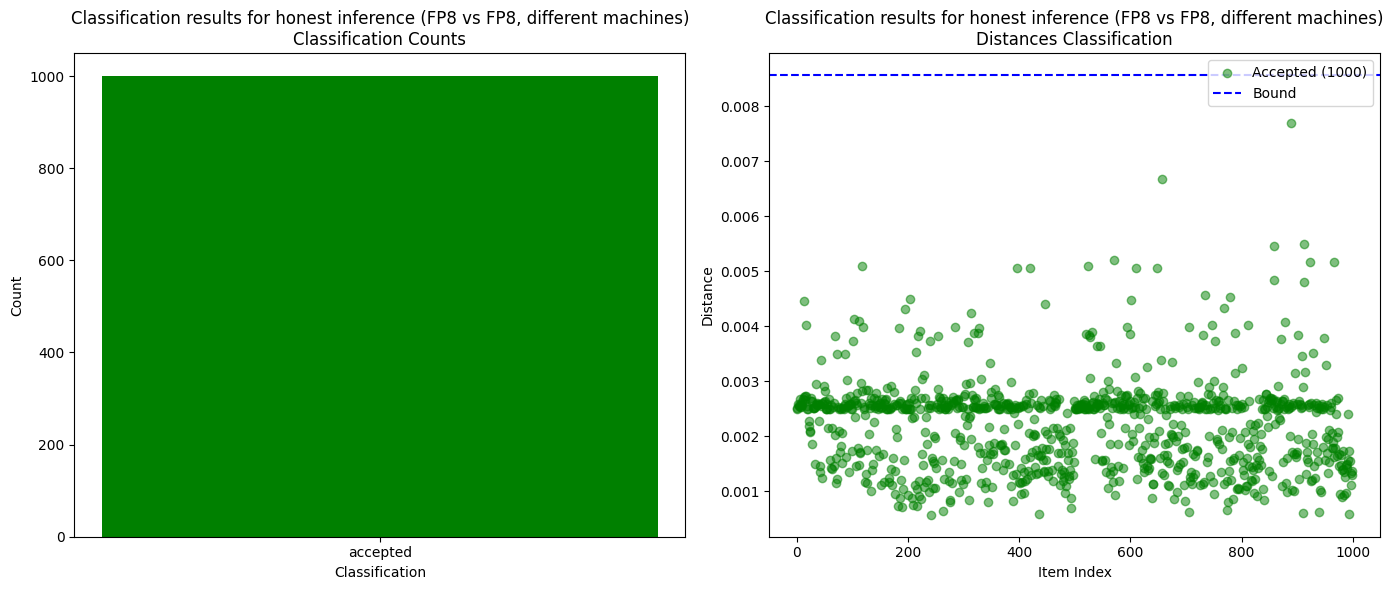

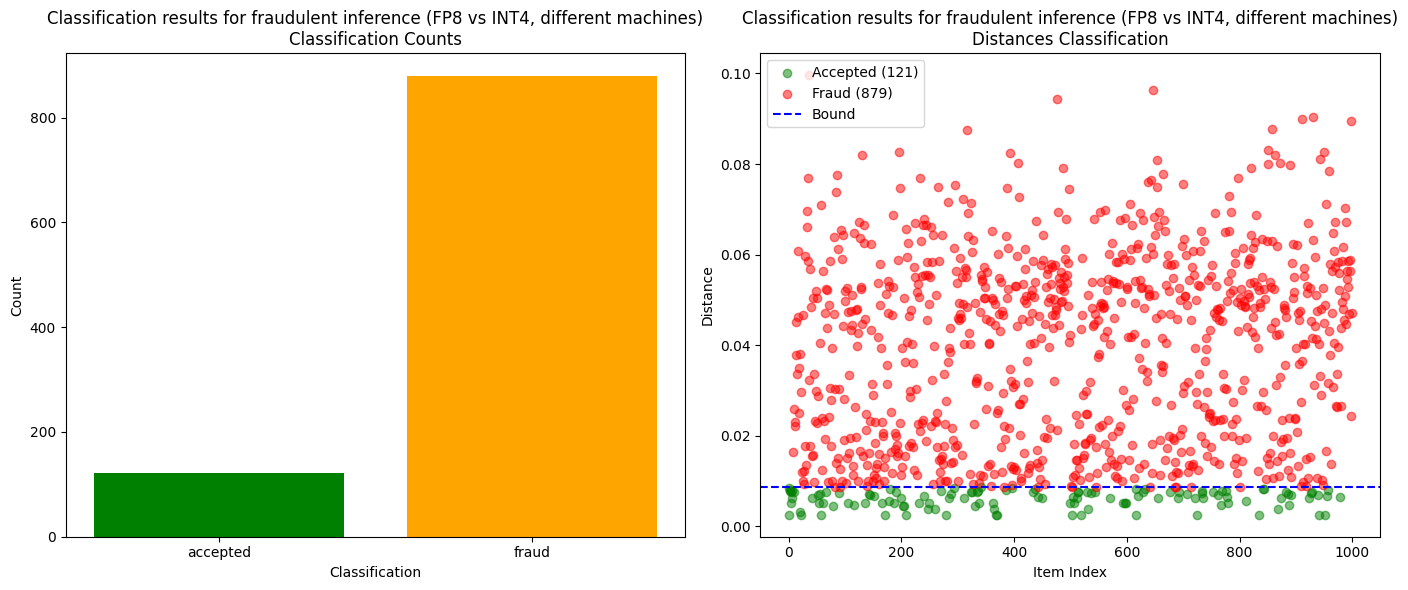

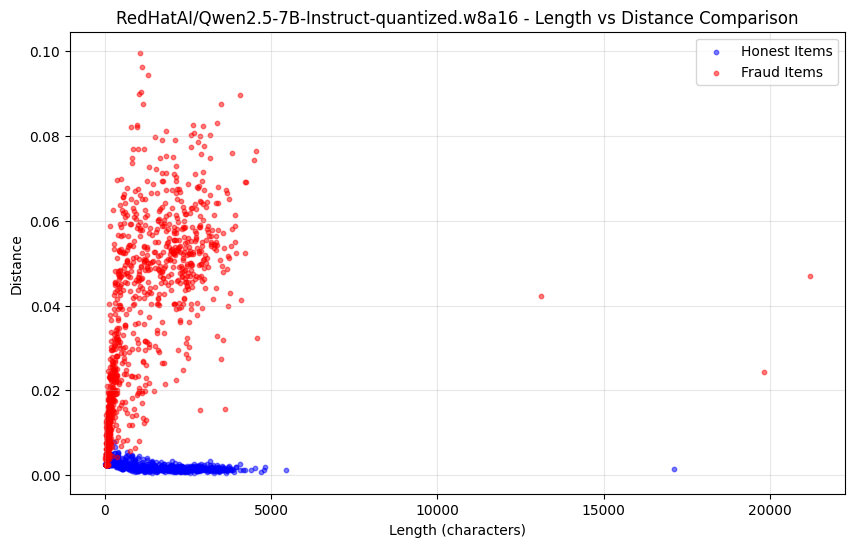

In [4]:
name = "RedHatAI/Qwen2.5-7B-Instruct-quantized.w8a16"
comparison = comparisons[name]
plot_results(name, comparison)

### Results

1. FP = 0 => all honest inferences are marked as honest
2. TN = 0.879 

## Qwen/Qwen3-32B-FP8

That model intends to replace existing `Qwen/QwQ-32B` as it's newer and higher quality. The model uses static quantization for weight but not activation.

Servers for honest validation:
- 1xH100
- 4x3090


Searching optimal bounds: 100%|██████████| 91/91 [00:00<00:00, 52149.43it/s]


Optimal Lower Bound: 0.041860
Best F1-Score: 0.9955


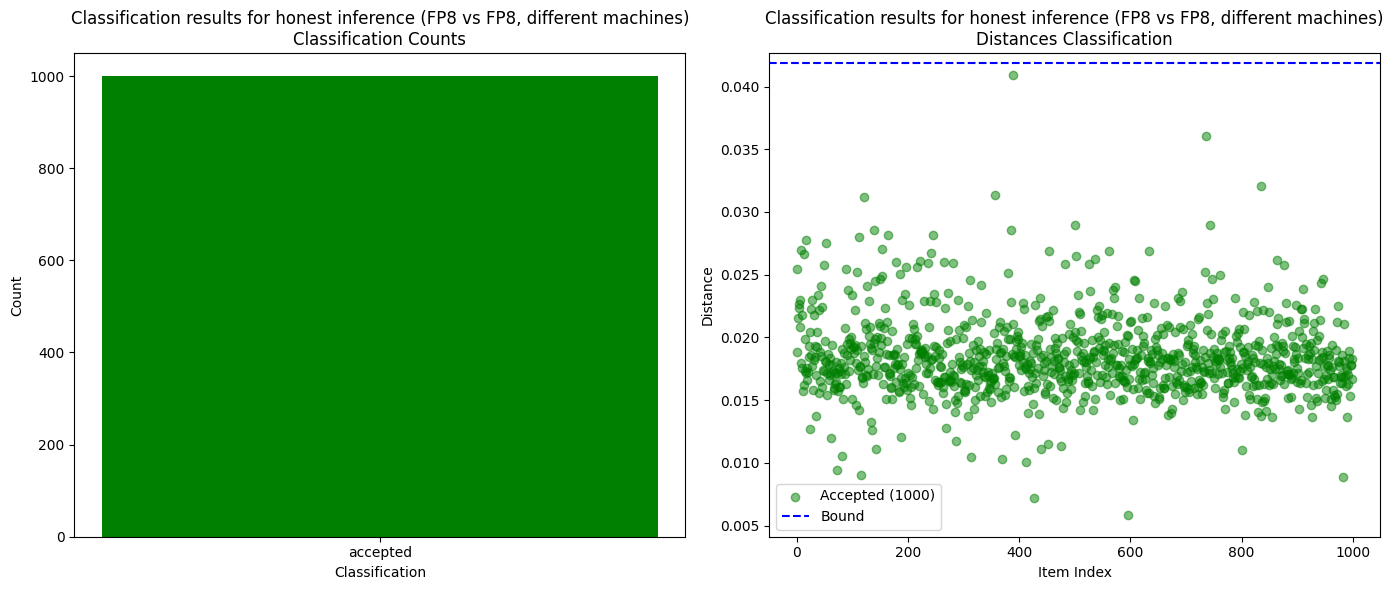

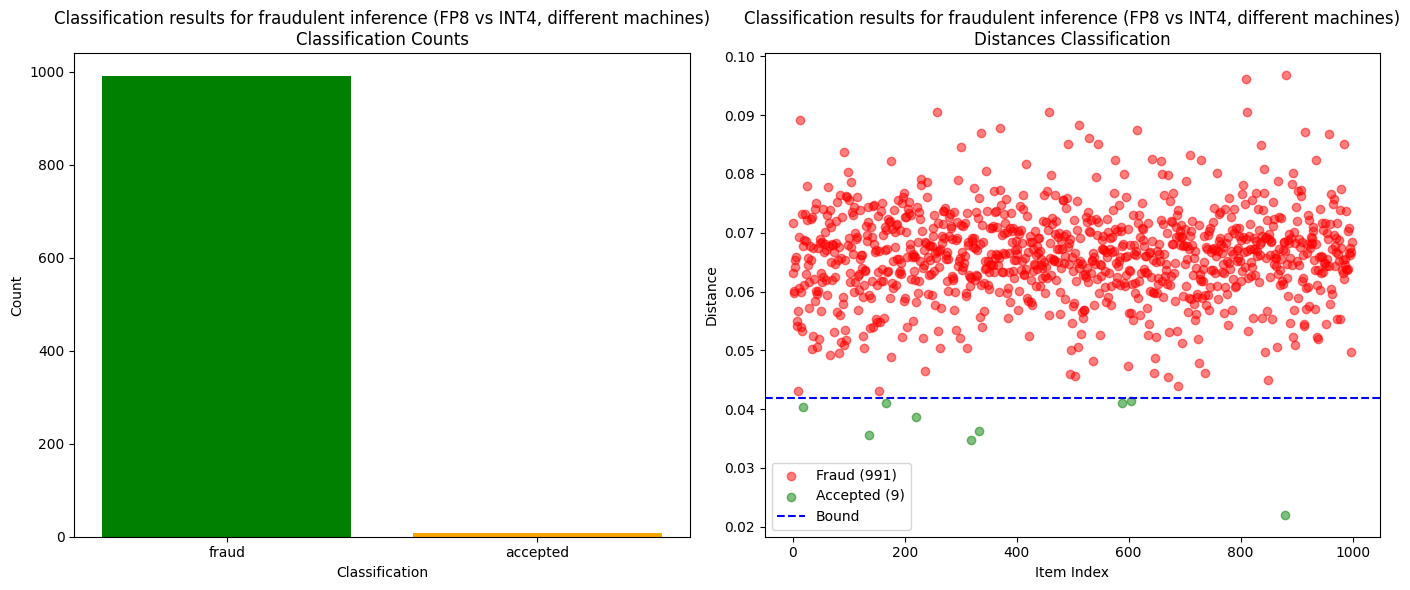

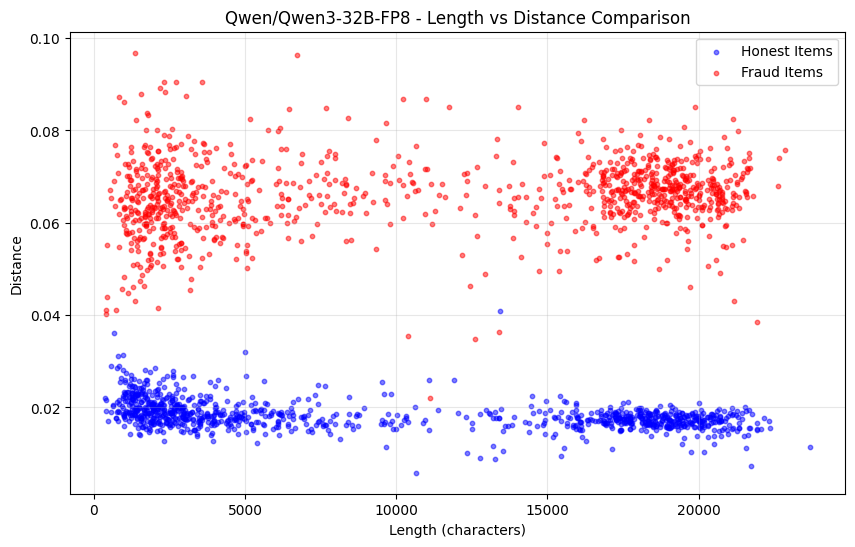

In [5]:
name = "Qwen/Qwen3-32B-FP8"
comparison = comparisons[name]
plot_results(name, comparison)

### Results

1. FP = 0 => all honest inferences are marked as honest
2. TN = 0.991

## Qwen/Qwen3-235B-A22B-Instruct-2507-FP8

The model is introduced as first in large models category. The model uses static quantization for weight but not activation.

Servers for honest validation:  
- 8xH100
- 8xH100 (different one)


Searching optimal bounds: 100%|██████████| 117/117 [00:00<00:00, 68710.94it/s]


Optimal Lower Bound: 0.029083
Best F1-Score: 0.6053


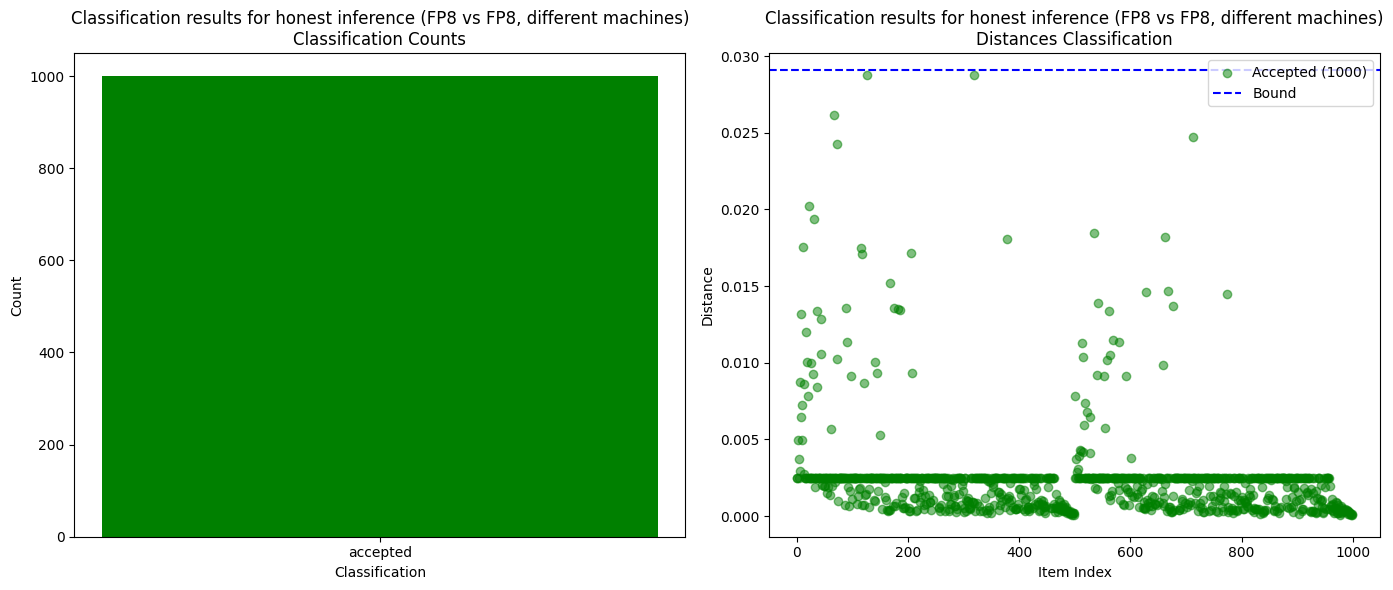

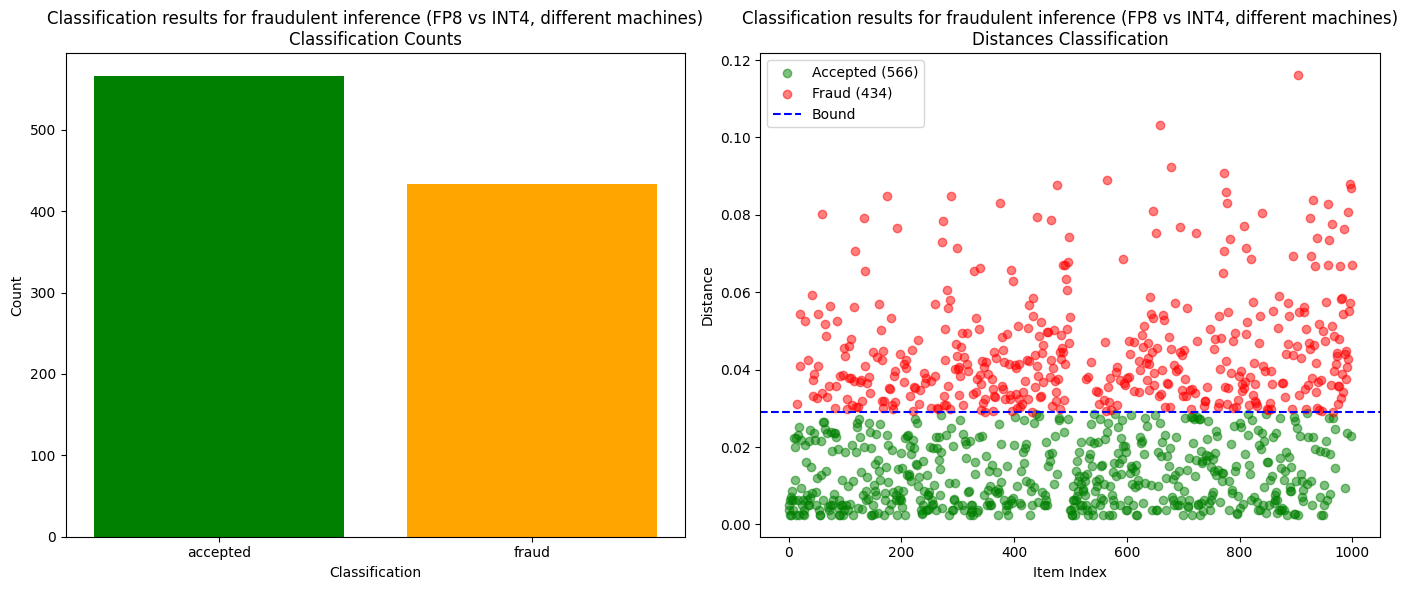

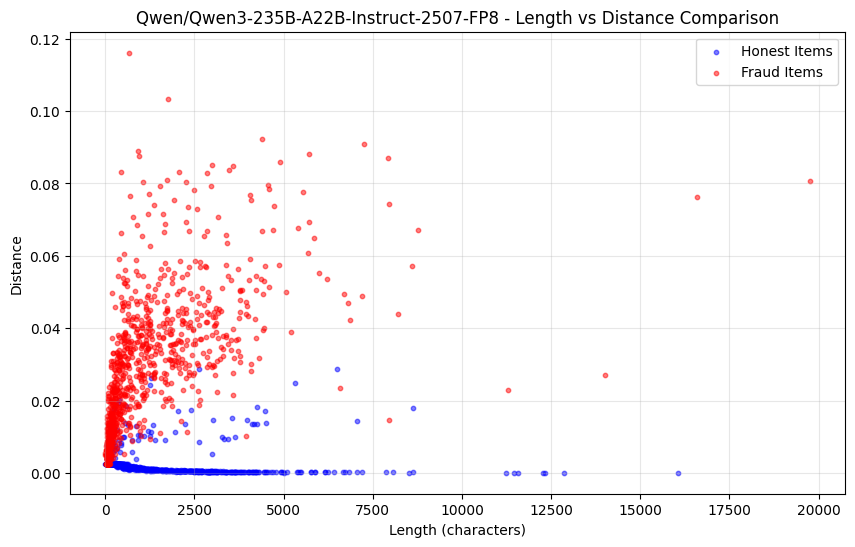

In [6]:
name = "Qwen/Qwen3-235B-A22B-Instruct-2507-FP8"
comparison = comparisons[name]
plot_results(name, comparison)

### Results

1. FP = 0 => all honest inferences are marked as honest
2. TN = 0.434

This TN is lower then for another models but still signigicantly higher that noise the system accept and it's enough to detect even minor difference in models. Changes in distance functions allows to increase TN to ~0.7.